<a href="https://colab.research.google.com/github/johnatanDM/MachineLearning/blob/main/HOMLwSKL%26TFcap3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Classificação

Baixando o dataset MNIST

In [ ]:
from sklearn.datasets import fetch_openml
X,y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

In [ ]:
X.shape

(70000, 784)

In [ ]:
y.shape

(70000,)

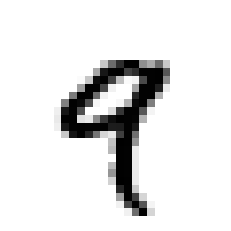

In [ ]:
#vamos ver um exemplo desse dataset
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[4]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [ ]:
y[36000]

'9'

In [ ]:
#separar conjunto de treino e conjunto de teste
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [ ]:
#emabaralhar o conjunto de treino
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

Treinando um Classificador binário

In [ ]:
y_train_9 = (y_train == '9')
y_test_9 = (y_test == '9')
print(y_train_9)
y_train[0]

[False False False ... False False False]


'8'

In [ ]:
# np.unique(y_test_9)

In [ ]:
#iremos usar o SGD - Gradiente Descendente Estocástico
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42, max_iter=2000)
sgd_clf.fit(X_train, y_train_9)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=2000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
#fazendo as predições
sgd_clf.predict([some_digit])

array([False])

Medindo o desempenho

In [ ]:
#Validação cruzada
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_9):
  clone_cfl = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_9[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_9[test_index]

  clone_cfl.fit(X_train_folds, y_train_folds)
  y_pred = clone_cfl.predict(X_test_fold)
  n_corret = sum(y_pred == y_test_fold)
  print(n_corret / len(y_pred))

0.9491
0.7919
0.94485


In [ ]:
#utilizando a função cross_val_score()
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_9, cv=3, scoring="accuracy")

array([0.94755, 0.94705, 0.94955])

95% de acurácia parece incrível, mas e se fizermos um classificador ridículo que apenas diz que todos não são 9. Quanto será que ele acerta?

In [ ]:
from sklearn.base import BaseEstimator

class Never9Classifier(BaseEstimator):
  def fit(self, X, y=None):
    pass
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

never_9_clf = Never9Classifier()
cross_val_score(never_9_clf, X_train, y_train_9, cv=3, scoring="accuracy")

array([0.9006 , 0.89985, 0.9021 ])

Sim, 90% de acurácia. Isso é pq só 10% das imagens são "9" então se sempre chutar "Não 9" vai acertar 90% das vezes.

Matriz de Confusão

In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_9, cv=3)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_9, y_train_pred)

array([[52214,  1837],
       [ 1280,  4669]])

O importante da Matrix de confusão é aprender que as linhas representam a classe real e as colunas as classes previstas.


```
   S  N
S VP  FN
N FP  VN
```



Precisão e Revocação

In [ ]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_9, y_train_pred))
print(recall_score(y_train_9, y_train_pred))

0.7176452505379649
0.7848377878635064


Isso significa que nosso modelo só acerta 68% das vezes em que diz que é um '9' e só detecta 82% dos '9'

Uma outra métrica combina precissão e revocação é a *pontuação F1*. Isso é útil para comparar classificadores.

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_train_9, y_train_pred)

0.7497390606182255

A pontuação F1 favorece classificadores com precisão e revocação similares. Nem sempre isso é o que queremos. Por exemplo se você está criando um classificador que dectecta se um vídeo é adequado para crianças é preferível que ele bloqueie bons vídeos (baixa revocação)(-FP) e mantivesse somente os adequados (alta precisão)(+VP). Não dá pra conseguir os dois altos infelizmente.

In [ ]:
# Compensação da Precisão/Revocação
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[-216.79353983]
[False]


In [ ]:
threshold = -200000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[ True]


In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_9, cv=3, method="decision_function")

In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_9, y_scores)

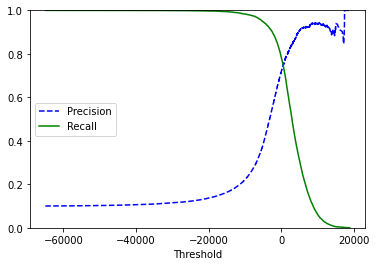

In [ ]:
def plt_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
  plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
  plt.xlabel("Threshold")
  plt.legend(loc="center left")
  plt.ylim([0,1])

plt_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [ ]:
y_train_pred_95 = (y_scores > 10000)

print(precision_score(y_train_9, y_train_pred_95))
print(recall_score(y_train_9, y_train_pred_95))

0.9390862944162437
0.06219532694570516


A curva ROC

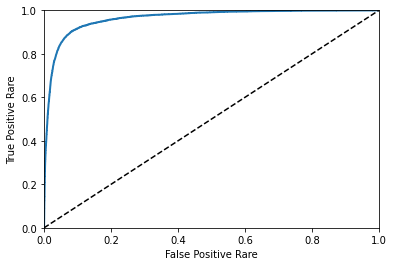

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_9, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1],[0,1], 'k--')
  plt.axis([0, 1, 0, 1])
  plt.xlabel('False Positive Rare')
  plt.ylabel('True Positive Rare')

plot_roc_curve(fpr, tpr)
plt.show()

In [ ]:
#ROC AUC (ÁREA ABAIXO DA CURVA)
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_9, y_scores)

0.9635365979956317

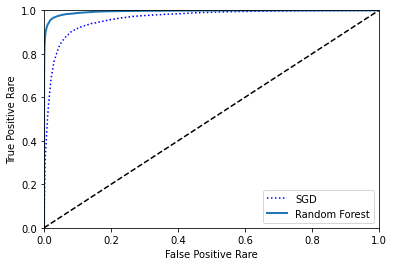

In [ ]:
#comparar curva ROC com o RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_9, cv=3, method="predict_proba")

y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_9, y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [ ]:
roc_auc_score(y_train_9, y_scores_forest)

0.9950918785576707

#Classificação Multiclasse

In [ ]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['9'], dtype='<U1')

In [ ]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-33836.03620204, -24038.78446959, -22815.32218394,
        -11242.93713614,  -5669.638277  , -12385.43019681,
        -27075.90747705, -11229.15545362,  -5062.42685809,
          -294.95450812]])

In [ ]:
print(np.argmax(some_digit_scores))
print(sgd_clf.classes_)
print(sgd_clf.classes_[9])

9
['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
9


para forçar o Scikit-Learn a usar *um contra um* ou *um contra todos*, podemos utlizar a Classe `OneVsOneClassifier` ou a `OneVsRestClassifier`

In [ ]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
print(ovo_clf.predict([some_digit]))
print(len(ovo_clf.estimators_))

['9']
45


Random Forest

In [ ]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array(['9'], dtype=object)

In [ ]:
forest_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.01, 0.01, 0.02, 0.  , 0.  , 0.01, 0.01, 0.94]])

In [ ]:
#avaliando os classificadores
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.8648 , 0.89005, 0.8764 ])

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.9015 , 0.90475, 0.9018 ])

Análise de Erro

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

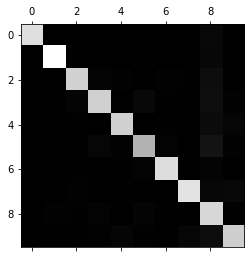

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Classificação Multilabel

In [50]:
from sklearn.neighbors import KNeighborsClassifier

y_train_integer = [int(number) for number in y_train]
y_train_large = [number >= 7 for number in y_train_integer]
y_train_odd = [number % 2 == 1 for number in y_train_integer]
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

knn_clf.predict([some_digit])

array([[ True,  True]])

In [51]:
#Avaliando um classificador multilabel
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976895635391503